In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def read_data(file_path):
    """
    Perform a stratified split on the dataset and save the training and testing sets.

    Parameters:
        file_path (str): Path to the input dataset (TSV file).
    """
    # Load the dataset
    data = pd.read_csv(file_path, sep="\t")

    # Verify the structure of the dataset
    print("Dataset preview:")
    print(data.head())

    # Split the dataset into features (X) and labels (y)
    X = data.drop(columns=["label"])
    y = data["label"]

    # Perform stratified split (95% training, 5% testing)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.05, stratify=y, random_state=42
    )

    # Combine the features and labels back for training and testing datasets
    train_data = pd.concat([X_train, y_train], axis=1)
    test_data = pd.concat([X_test, y_test], axis=1)

    #print(f"Stratified split completed. Training data saved to {output_train} and testing data saved to {output_test}.")
    return train_data, test_data



In [ ]:
train_data_orientation,test_data_orientation=read_data("orientation-nl-train.tsv")
train_data_power,test_data_power=read_data("power-nl-train.tsv")

Dataset preview:
        id                           speaker sex  \
0  nl00000  b0eea2e341080aedbdcfad0eb7ccfc6e   F   
1  nl00001  b0eea2e341080aedbdcfad0eb7ccfc6e   F   
2  nl00002  b0eea2e341080aedbdcfad0eb7ccfc6e   F   
3  nl00003  b0eea2e341080aedbdcfad0eb7ccfc6e   F   
4  nl00004  b0eea2e341080aedbdcfad0eb7ccfc6e   F   

                                                text  \
0  Voorzitter. Goedemorgen. Het is een bijzondere...   
1  Met alle respect voor mijn collega Ouwehand. I...   
2  Ten aanzien van de vergunningsvrije activiteit...   
3  Volgens mij is dit een heel goed moment om de ...   
4  Mevrouw Lodders van de <PARTY> zegt: we willen...   

                                             text_en  label  
0  Mr. Chairman. Good morning. It's a special day...      0  
1  With all due respect to my colleague Ouwehand....      0  
2  With regard to the authorisation-free activiti...      0  
3  I believe that this is a very good time to inv...      0  
4  Mrs Lodders of the <

In [ ]:
def check_balance(data, label_column="label", threshold=10):
    """
    Determine if a dataset is balanced and provide detailed label distribution.

    Parameters:
        data (pd.DataFrame): The dataset to analyze.
        label_column (str): The column name containing the labels.
        threshold (float): Maximum allowed percentage difference between classes to consider balanced.

    Returns:
        str: A message about dataset balance and label proportions.
    """
    label_counts = data[label_column].value_counts(normalize=True) * 100  # Calculate proportions in %
    total = data.shape[0]
    most_common_label = label_counts.idxmax()
    least_common_label = label_counts.idxmin()
    max_diff = label_counts.max() - label_counts.min()  # Difference between largest and smallest proportions

    if max_diff <= threshold:
        balance_status = "The dataset is balanced"
    else:
        balance_status = "The dataset is NOT balanced"

    message = (
        f"{balance_status} (Max difference: {max_diff:.2f}%).\n"
        f"Label '{most_common_label}' is the majority with {label_counts[most_common_label]:.2f}% "
        f"({int(total * label_counts[most_common_label] / 100)} samples).\n"
        f"Label '{least_common_label}' is the minority with {label_counts[least_common_label]:.2f}% "
        f"({int(total * label_counts[least_common_label] / 100)} samples)."
    )

    return message

orientation_balance_msg = check_balance(train_data_orientation)
power_balance_msg = check_balance(train_data_power)

print("Orientation Dataset:\n", orientation_balance_msg)
print("\nPower Dataset:\n", power_balance_msg)


Orientation Dataset:
 The dataset is NOT balanced (Max difference: 23.15%).
Label '1' is the majority with 61.57% (3309 samples).
Label '0' is the minority with 38.43% (2064 samples).

Power Dataset:
 The dataset is NOT balanced (Max difference: 16.99%).
Label '0' is the majority with 58.50% (4393 samples).
Label '1' is the minority with 41.50% (3117 samples).


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

def fine_tune_multilingual_bert(train_data, test_data, output_dir, epochs, batch_size=16,task="orientation"):
    """
    Fine-tune a multilingual BERT model for a binary classification task.

    Parameters:
        train_data (pd.DataFrame): Training data as a pandas DataFrame.
        test_data (pd.DataFrame): Testing data as a pandas DataFrame.
        output_dir (str): Directory to save the fine-tuned model.
        epochs (int): Number of epochs for training.
        batch_size (int): Batch size for training.
    """
    # Initialize tokenizer and model
    model_name = "bert-base-multilingual-cased"
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

    # Convert pandas DataFrames to Hugging Face Datasets
    train_dataset = Dataset.from_pandas(train_data)

    # Tokenize the datasets
    def preprocess_function(examples,task):
      if task=="orientation":
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)
      else:
        return tokenizer(examples["text_en"], padding="max_length", truncation=True, max_length=128)



    #tokenized_train = train_dataset.map(preprocess_function(task=task), batched=True)
    tokenized_train = train_dataset.map(lambda examples: preprocess_function(examples,task=task), batched=True)

    # Prepare for PyTorch (required for Trainer)
    tokenized_train = tokenized_train.map(lambda x: {'labels': x['label']})
    tokenized_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

    # Define training arguments
    training_args = TrainingArguments(
        evaluation_strategy="no",
        save_strategy="no",
        logging_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        logging_dir=None,
        output_dir=output_dir,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",  # Select the best model based on loss
        greater_is_better=False,  # Lower loss is better
        report_to=[]  # Disable W&B integration
    )

    # Define the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        tokenizer=tokenizer,
    )

    # Train the model
    trainer.train()

    # Save the fine-tuned model
    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)

    print(f"Fine-tuning completed. Model saved to {output_dir}")


In [ ]:
fine_tune_multilingual_bert(train_data_orientation, test_data_orientation, "output/orientation_model", epochs=10, batch_size=16,task="orientation")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5374 [00:00<?, ? examples/s]

Map:   0%|          | 0/5374 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-22-ed068d126d2a>:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
336,0.666900
672,0.667500
1008,0.655900
1344,0.627100
1680,0.559100
2016,0.458200
2352,0.353900
2688,0.273000
3024,0.215700
3360,0.181500


Fine-tuning completed. Model saved to output/orientation_model


In [ ]:
fine_tune_multilingual_bert(train_data_power, test_data_power, "output/power_model", epochs=10, batch_size=16, task="power")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7510 [00:00<?, ? examples/s]

Map:   0%|          | 0/7510 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-22-ed068d126d2a>:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
470,0.672800
940,0.626700
1410,0.533200
1880,0.375600
2350,0.244300
2820,0.186500
3290,0.128800
3760,0.086900
4230,0.068700
4700,0.043700


Fine-tuning completed. Model saved to output/power_model


In [ ]:

def preprocess_function(examples,task):
  model_name = "bert-base-multilingual-cased"
  tokenizer = BertTokenizer.from_pretrained(model_name)
  if task=="orientation":
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)
  else:
    return tokenizer(examples["text_en"], padding="max_length", truncation=True, max_length=128)


def create_test_dataset(test_data,task):
  test_dataset = Dataset.from_pandas(test_data)
  tokenized_test = test_dataset.map(lambda examples: preprocess_function(examples,task=task), batched=True)
  tokenized_test = tokenized_test.map(lambda x: {'labels': x['label']})
  tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
  return tokenized_test


In [ ]:
tokenized_test_orientation=create_test_dataset(test_data_orientation,"orientation")
tokenized_test_power=create_test_dataset(test_data_power,"power")

Map:   0%|          | 0/283 [00:00<?, ? examples/s]

Map:   0%|          | 0/283 [00:00<?, ? examples/s]

Map:   0%|          | 0/396 [00:00<?, ? examples/s]

Map:   0%|          | 0/396 [00:00<?, ? examples/s]

Model checkpoint: output/orientation_model
Test Accuracy: 56.18%
              precision    recall  f1-score   support

           0       0.44      0.50      0.47       109
           1       0.66      0.60      0.63       174

    accuracy                           0.56       283
   macro avg       0.55      0.55      0.55       283
weighted avg       0.57      0.56      0.57       283



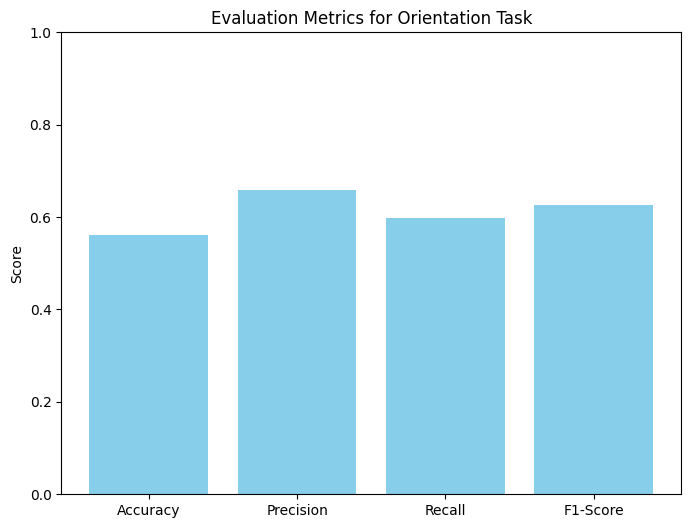

Model checkpoint: output/power_model
Test Accuracy: 59.09%
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       232
           1       0.51      0.48      0.49       164

    accuracy                           0.59       396
   macro avg       0.58      0.57      0.58       396
weighted avg       0.59      0.59      0.59       396



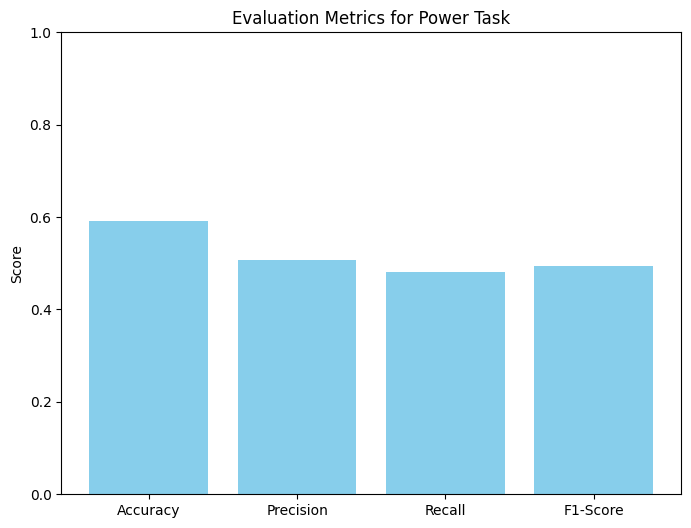

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def evaluate_saved_model(checkpoint_dir, test_data, batch_size=16, task_name="Task"):
    """
    Evaluate a saved model on the test dataset and calculate metrics.

    Parameters:
        checkpoint_dir (str): Directory where the model checkpoint is saved.
        test_data (Dataset): Tokenized test dataset.
        batch_size (int): Batch size for evaluation.
        task_name (str): Name of the task for display purposes.
    """
    # Load the tokenizer and model from the checkpoint
    tokenizer = BertTokenizer.from_pretrained(checkpoint_dir)
    model = BertForSequenceClassification.from_pretrained(checkpoint_dir)
    model.eval()

    # Create DataLoader for the test dataset
    test_loader = DataLoader(test_data, batch_size=batch_size)

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Initialize metrics
    all_labels = []
    all_predictions = []

    # Evaluate the model
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)

            all_labels.extend(labels.cpu().tolist())
            all_predictions.extend(predictions.cpu().tolist())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average="binary")
    recall = recall_score(all_labels, all_predictions, average="binary")
    f1 = f1_score(all_labels, all_predictions, average="binary")

    print(f"Model checkpoint: {checkpoint_dir}")
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print(classification_report(all_labels, all_predictions))

    # Plot the metrics
    metrics = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1}
    plt.figure(figsize=(8, 6))
    plt.bar(metrics.keys(), metrics.values(), color="skyblue")
    plt.ylim(0, 1)
    plt.title(f"Evaluation Metrics for {task_name}")
    plt.ylabel("Score")
    plt.show()


evaluate_saved_model("output/orientation_model", tokenized_test_orientation, batch_size=16, task_name="Orientation Task")
evaluate_saved_model("output/power_model", tokenized_test_power, batch_size=16, task_name="Power Task")


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
!pip install --upgrade transformers torch

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import transformers
import torch
import pandas as pd

import torch
import pandas as pd
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# Model pipeline setup
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.float16
)

chat_pipeline = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=False,
    max_new_tokens=50,
    temperature=0.0,         # Greedy
    do_sample=False
)


def classify_text_via_chat(text: str, task: str) -> str:

    """
    Chat-based classifier:
      - If task='orientation', respond ONLY with 'left' or 'right'.
      - If task='power', respond ONLY with 'government' or 'opposition'.
    """

    if task == "orientation":
        system_message = {
            "role": "system",
            "content": (
                "You are a helpful assistant. Classify the speaker's party ideology as "
                "'left' or 'right'. Respond ONLY with 'left' or 'right'. No extra explanation."
            ),
        }
    elif task == "power":
        system_message = {
            "role": "system",
            "content": (
                "You are a helpful assistant. Classify the speaker's party as "
                "'government' or 'opposition'. Respond ONLY with 'government' or 'opposition'."
            ),
        }
    else:
        raise ValueError("Unknown task. Must be either 'orientation' or 'power'.")

    user_message = {
        "role": "user",
        "content": text
    }

    response = chat_pipeline([system_message, user_message])
    # The pipeline returns a list with one item like [{'generated_text': 'right'}].
    return response[0]["generated_text"].strip().lower()


def infer_with_pipeline(test_data: pd.DataFrame, task: str) -> dict:

    """
    Perform inference using a chat-based pipeline with the Llama model.

    Parameters:
        test_data (pd.DataFrame): must have some text columns, e.g. 'text' or 'text_en'
        task (str): 'orientation' => classify as 'left' or 'right'
                    'power' => classify as 'government' or 'opposition'

    Returns:
        dict: { column_name: [classification_results...] }
    """

    results = {}

    columns_to_classify = ["text","text_en"]

    for col in columns_to_classify:
        pred_list = []
        for text in test_data[col]:
            # Call the classifier
            classification = classify_text_via_chat(text, task=task)
            #print(classification)
            pred_list.append(classification)
        results[col] = pred_list

    return results



Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def evaluate_inference(predictions, test_data, task_name):
    """
    Evaluate predictions using ground truth labels and plot metrics.

    Parameters:
        predictions (dict): Dictionary containing predictions for both original and English text.
        test_data (pd.DataFrame): Test data containing ground truth labels (0 or 1).
        task_name (str): Name of the task for display purposes.
    """
    metrics = {}
    ground_truth = test_data["label"].tolist()  # Ground truth labels

    for text_type, preds in predictions.items():
        if len(preds) != len(ground_truth):
            print(f"Warning: Mismatch in prediction and label lengths for {text_type}. Skipping evaluation.")
            continue

        # ---- Convert -1 to the OPPOSITE of ground_truth
        preds_binary = []
        for p, g in zip(preds, ground_truth):
            if p == -1:
                # Force incorrect by flipping the ground truth:
                flipped_label = 1 - g if g in [0, 1] else 1  # fallback to 1 if ground_truth not in [0,1]
                preds_binary.append(flipped_label)
            else:
                preds_binary.append(p)

        # Calculate metrics using these predictions
        accuracy = accuracy_score(ground_truth, preds_binary)
        precision = precision_score(ground_truth, preds_binary, average="binary")
        recall = recall_score(ground_truth, preds_binary, average="binary")
        f1 = f1_score(ground_truth, preds_binary, average="binary")

        metrics[text_type] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
        }

        # Print metrics
        print(f"Metrics for {task_name} ({text_type}):")
        print(f"  Accuracy: {accuracy * 100:.2f}%")
        print(f"  Precision: {precision:.2f}")
        print(f"  Recall: {recall:.2f}")
        print(f"  F1-Score: {f1:.2f}\n")

    # Plot metrics
    for text_type, metric_values in metrics.items():
        plt.figure(figsize=(8, 6))
        plt.bar(metric_values.keys(), metric_values.values(), color="skyblue")
        plt.ylim(0, 1)
        plt.title(f"Metrics for {task_name} ({text_type})")
        plt.ylabel("Score")
        plt.xlabel("Metric")
        plt.xticks(rotation=45)
        plt.show()


In [ ]:
# Perform inference for orientation task
orientation_predictions = infer_with_pipeline(
    test_data=test_data_orientation,
    task="orientation",
)

print("Orientation Results (Original Text):", orientation_predictions["text"])
print("Orientation Results (English Text):", orientation_predictions["text_en"])

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Orientation Results (Original Text): ['left', 'left', 'left', 'left', 'rechts', 'left', 'left', 'links', 'left', 'left', 'links', 'rechts', 'left', 'left', 'left', 'left', 'left', 'links', 'links', 'left', 'left', 'left', 'left', 'links', 'left', 'left', 'left', 'left', 'left', 'links', 'left', 'links', 'links', 'left', 'right', 'left', 'left', 'links', 'left', 'left', 'left', 'left', 'left', 'links', 'left', 'left', 'rechts', 'left', 'left', 'left', 'left', 'rechts', 'left', 'links', 'left', 'left', 'left', 'left', 'left', 'links', 'left', 'links', 'left', 'rechts', 'left', 'left', 'left', 'left', 'left', 'left', 'rechts', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'links', 'rechts', 'links', 'left', 'left', 'left', 'left', 'left', 'links', 'links', 'left', 'rechts', 'left', 'rechts', 'left', 'left', 'left', 'links', 'left', 'links', 'links', 'left', 'left', 'left', 'links', 'left', 'left', 'left', 'links', 'links', 'left', 'left', 'left', 'left', 'left', 

In [ ]:
# Mapped results (Original Text)
mapped_text = []
for label in orientation_predictions["text"]:
    # normalize to lowercase to avoid case issues
    label_lower = label.lower()
    if label_lower in ["left", "links"]:
        mapped_text.append(0)
    elif label_lower in ["right", "rechts"]:
        mapped_text.append(1)
    else:
        mapped_text.append(-1)

# Mapped results (English Text)
mapped_text_en = []
for label in orientation_predictions["text_en"]:
    label_lower = label.lower()
    if label_lower in ["left", "links"]:
        mapped_text_en.append(0)
    elif label_lower in ["right", "rechts"]:
        mapped_text_en.append(1)
    else:
        mapped_text_en.append(-1)

# Show intermediate results
print("Mapped Orientation (Original Text):", mapped_text)
print("Mapped Orientation (English Text):", mapped_text_en)

# Create a new dictionary in the same structure as 'orientation_predictions'
mapped_orientation_predictions = {
    "text": mapped_text,
    "text_en": mapped_text_en
}

# Final output retaining the same structure
print("\nMapped Orientation Predictions Dictionary:")
print(mapped_orientation_predictions)


Mapped Orientation (Original Text): [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Mapped Orientation (English Text): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0

In [ ]:
# Perform inference for power task
power_predictions = infer_with_pipeline(
    test_data=test_data_power,
    task="power"
)

print("Power Results (Original Text):", power_predictions["text"])
print("Power Results (English Text):", power_predictions["text_en"])

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_

Power Results (Original Text): ['opposition', 'government', 'government', 'government', 'government', 'opposition', 'opposition', 'government', 'oppositie', 'oppositie', 'oppositie', 'opposition', 'government', 'government', 'government', 'government', 'government', 'government', 'opposition', 'oppositie', 'opposition', 'government', 'oppositie', 'opposition', 'oppositie', 'government', 'oppositie', 'government', 'oppositie', 'oppositie', 'oppositie', 'government', 'opposition', 'government', 'oppositie', 'oppositie', 'government', 'government', 'government', 'oppositie', 'opposition', 'government', 'government', 'oppositie', 'government', 'government', 'opposition', 'oppositie', 'government', 'oppositie', 'government', 'government', 'oppositie', 'government', 'government', 'opposition', 'opposition', 'government', 'government', 'oppositie', 'oppositie', 'government', 'government', 'oppositie', 'opposition', 'government', 'government', 'government', 'oppositie', 'oppositie', 'oppositio

In [ ]:
# Mapped results (Original Text)
mapped_text = []
for label in power_predictions["text"]:
    # normalize to lowercase to avoid case issues
    label_lower = label.lower()
    if label_lower in ["opposition", "oppositie"]:
        mapped_text.append(1)
    elif label_lower in ["government"]:
        mapped_text.append(0)
    else:
        mapped_text.append(-1)

# Mapped results (English Text)
mapped_text_en = []
for label in power_predictions["text_en"]:
    label_lower = label.lower()
    if label_lower in ["opposition", "oppositie"]:
        mapped_text_en.append(1)
    elif label_lower in ["government"]:
        mapped_text_en.append(0)
    else:
        mapped_text_en.append(-1)

# Show intermediate results
print("Mapped Power (Original Text):", mapped_text)
print("Mapped Power (English Text):", mapped_text_en)

# Create a new dictionary in the same structure as 'orientation_predictions'
mapped_power_predictions = {
    "text": mapped_text,
    "text_en": mapped_text_en
}

# Final output retaining the same structure
print("\nMapped Power Predictions Dictionary:")
print(mapped_power_predictions)


Mapped Power (Original Text): [1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 

Metrics for Orientation Task (text):
  Accuracy: 42.76%
  Precision: 0.73
  Recall: 0.11
  F1-Score: 0.19

Metrics for Orientation Task (text_en):
  Accuracy: 47.35%
  Precision: 0.90
  Recall: 0.16
  F1-Score: 0.27



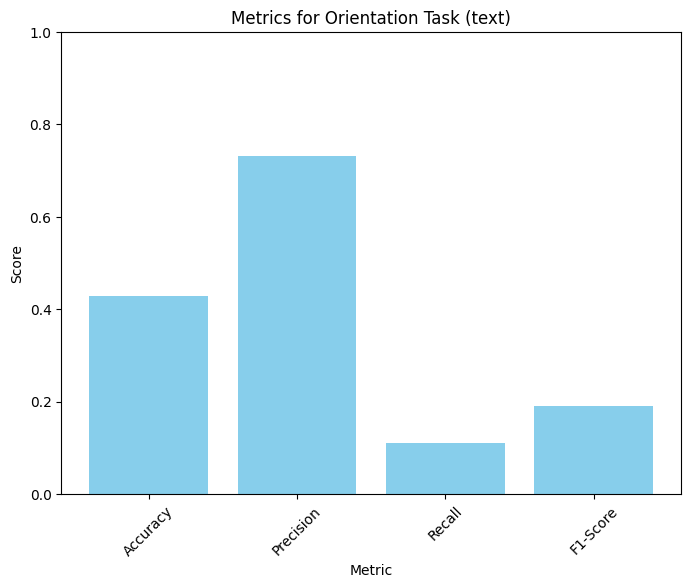

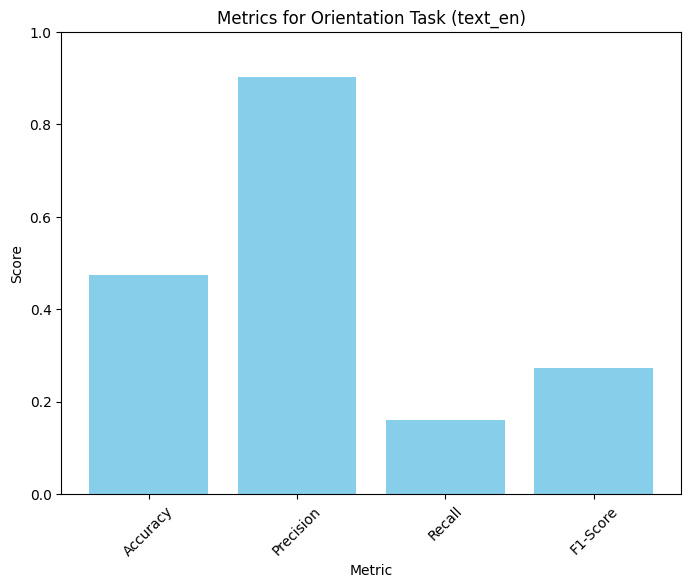

In [ ]:
# Evaluate orientation predictions
evaluate_inference(mapped_orientation_predictions, test_data_orientation, task_name="Orientation Task")


Metrics for Power Task (text):
  Accuracy: 65.66%
  Precision: 0.57
  Recall: 0.66
  F1-Score: 0.62

Metrics for Power Task (text_en):
  Accuracy: 63.38%
  Precision: 0.58
  Recall: 0.41
  F1-Score: 0.48



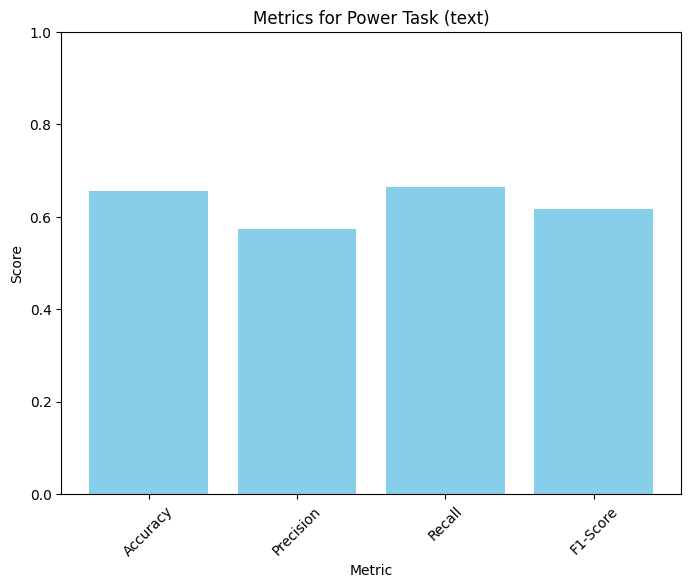

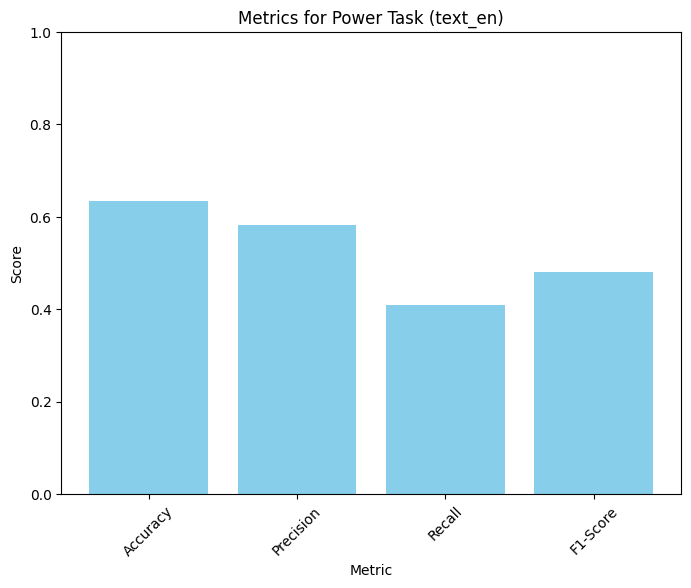

In [ ]:
# Evaluate power predictions
evaluate_inference(mapped_power_predictions, test_data_power, task_name="Power Task")